<a href="https://colab.research.google.com/github/belom-nlp/micro_topic_modelling/blob/main/notebooks/MTM_with_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we demonstrate how sentence embeddings are clustered in our model using UMAP library.

For each dataset, we use MicroTopicModeller to get topic words and print them out. Clusters that are semantically close to each other are mostly found next to each other on UMAP visualization.

#Installing MTM

In [1]:
from IPython.display import clear_output

!pip install -q umap-learn
!pip install -q --upgrade tbb
clear_output()

In [2]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn
clear_output()

In [3]:
!pip install umap-learn[plot]
clear_output()

In [4]:
! pip install sentence_transformers
! pip install transformers
clear_output()

In [5]:
#importing necessary libraries
from collections import Counter
import numpy as np
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import nltk

from transformers import AutoTokenizer
from transformers import BertModel
from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN, DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

In [6]:
import umap
import umap.plot

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
clear_output()

In [9]:
import torch

In [10]:
import random

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

In this notebook, simpler version of MicroTopicModeller is used. Please refer to model.py file in order to get detailed information about each function below.

Please note that comments are provided only for the first experiment.

In [11]:
class Trial_MicroTopicModeller():

  def __init__(self, n_clusters=None, sent_transformer='intfloat/multilingual-e5-base', method='count', stop_words='english'):
    self.n_clusters = n_clusters
    self.data = None
    self.sent_transformer = SentenceTransformer(sent_transformer)
    if method == 'count':
      self.vectorizer = CountVectorizer(stop_words=stop_words, max_features=40000)


  def get_embeddings(self, data):
    self.n_documents = len(data)
    self.data = sent_tokenize(data) #split by punctuation marks at the end of the sentence
    sent_embs = self.sent_transformer.encode(self.data) #sentence embeddings; an array of shape (self.n_documents, 768)

    return sent_embs

  def get_sentence_clusters(self, sent_embs):
    if self.n_clusters is not None:
      cluster_maker = KMeans(n_clusters = self.n_clusters)
    else:
      cluster_maker = HDBSCAN(min_cluster_size=3)
    cluster_maker.fit(sent_embs)
    n_clusters = len(np.unique(cluster_maker.labels_))
    emb_clusters = []
    sent_collection = []
    for j in range(n_clusters):
      emb_clusters.append(list())
      sent_collection.append(list())
      for i in range(len(self.data)):
        if cluster_maker.labels_[i] == j - 1: #because we have '-1' cluster /// CHECK FOR KMEANS!
          emb_clusters[j].append(sent_embs[i])
          sent_collection[j].append(self.data[i])
    return emb_clusters, sent_collection

In [12]:
def get_lda(vectorizer, sent_collection, cluster_number):
    part = vectorizer.transform(sent_collection[cluster_number])
    lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', random_state=0, verbose=0)
    lda_topic_matrix = lda_model.fit_transform(part)
    feature_names = vectorizer.get_feature_names_out()
    base_words = []
    for topic_idx, topic in enumerate(lda_model.components_):
      top_features_ind = topic.argsort()[: -5 - 1 : -1]
      words = []
      for i in range(5):
        words.append(feature_names[top_features_ind[i]])
      base_words.append(words)
    return base_words

def get_common_key_words(distr):
    raw_distr = []
    for wordgroup in distr:
      wg = wordgroup[1] + wordgroup[2] + wordgroup[3] + wordgroup[4] + wordgroup[0]
      raw_distr = raw_distr + wg # get all words from all classes
    word_counts = dict(Counter(raw_distr))
    base_words = [] # get pertinent words from all texts
    n_clusters = len(distr)
    for key, value in word_counts.items():
      if value >= n_clusters // 3:
        base_words.append(key)
    return base_words

def get_topic_words(distr, base_words):
    topics = {}
    for i, wordgroup in enumerate(distr):
      wg = wordgroup[1] + wordgroup[2] + wordgroup[3] + wordgroup[4] + wordgroup[0]
      group = list(set(wg) - set(base_words))
      groupname = 'topic' + str(i)
      topics[groupname] = group
    return topics

#Data processing

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
with open('/content/drive/MyDrive/iran_1.txt', 'r') as file:
  lines = file.read()

In [15]:
tmtm = Trial_MicroTopicModeller(n_clusters=12)
sent_embs = tmtm.get_embeddings(lines)
emb_clusters, sent_collection = tmtm.get_sentence_clusters(sent_embs)

.gitattributes:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/179k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

onnx/config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

onnx/special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

onnx/tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [16]:
#getting data for fitting UMAP
X = []
y = []
for i in range(1, len(sent_collection)):
    for j in range(len(sent_collection[i])):
        X.append(emb_clusters[i][j])
        y.append(i)

assert len(X) == len(y)

In [17]:
#fitting UMAP
md = umap.UMAP()
um = md.fit(X)

In [18]:
y = np.array(y)

In [19]:
data = tmtm.data

In [20]:
#get topic words
distributions = []
vectorizer = CountVectorizer(stop_words='english', max_features=40000)
vectorizer.fit(data)
for i in range(len(sent_collection)):
    if len(sent_collection[i]) > 0:
        base_words = get_lda(vectorizer, sent_collection, i)
        distributions.append(base_words)
    common_key_words = get_common_key_words(distributions)
    topic_words = get_topic_words(distributions, common_key_words)
    topic_words['common_key_words'] = common_key_words

In [21]:
topic_words

{'topic0': ['vehicles',
  'videos',
  'teargas',
  'security',
  'bins',
  'posted',
  'footage',
  'forces',
  'video',
  'killed',
  'batons',
  'retreat'],
 'topic1': ['islamic',
  'regime',
  'dangerous',
  'day',
  'republic',
  'control',
  'resistance'],
 'topic2': ['independently',
  'detained',
  'does',
  'difficult',
  'days',
  'online',
  'men',
  'regime',
  'social',
  'organise',
  'story',
  'conciliatory',
  'conservative',
  'president',
  'country'],
 'topic3': ['new',
  'case',
  'met',
  'happened',
  'return',
  'weapons',
  'negotiator',
  'unilaterally',
  'speech'],
 'topic4': ['year',
  'old',
  'city',
  'province',
  'piranshahr',
  'september',
  'sought',
  'sites',
  'killed',
  'capital'],
 'topic5': ['sought',
  'turn',
  'case',
  'mistakes',
  'signs',
  'deaths',
  'playbook',
  'measures',
  'treasury',
  'state',
  'final',
  'received',
  'independently',
  'called',
  'did',
  'promised',
  'investigated',
  'attack',
  'visiting',
  'saying',
 

<Axes: >

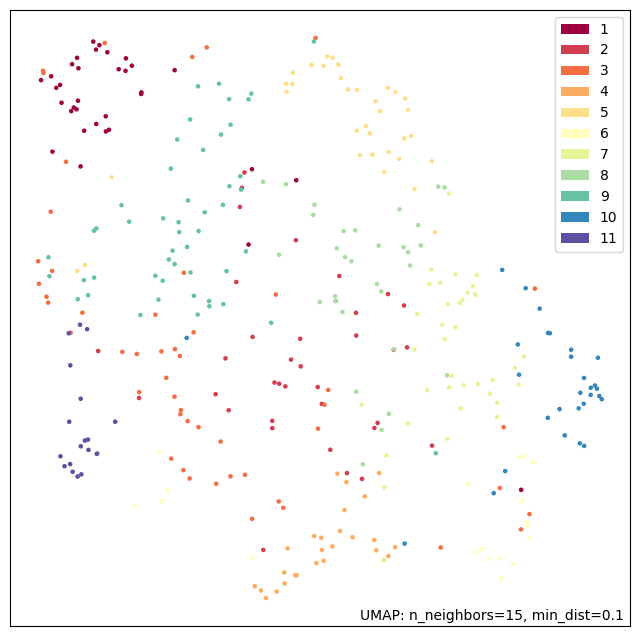

In [22]:
umap.plot.points(um, labels=y)

#Iran 1 with 18 clusters

In [23]:
tmtm = Trial_MicroTopicModeller(n_clusters=18)
sent_embs = tmtm.get_embeddings(lines)
emb_clusters, sent_collection = tmtm.get_sentence_clusters(sent_embs)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
X = []
y = []
for i in range(1, len(sent_collection)):
    for j in range(len(sent_collection[i])):
        X.append(emb_clusters[i][j])
        y.append(i)

assert len(X) == len(y)

y = np.array(y)

In [25]:
md = umap.UMAP()
um = md.fit(X)

In [26]:
data = tmtm.data
distributions = []
vectorizer = CountVectorizer(stop_words='english', max_features=40000)
vectorizer.fit(data)
for i in range(len(sent_collection)):
    if len(sent_collection[i]) > 0:
        base_words = get_lda(vectorizer, sent_collection, i)
        distributions.append(base_words)
    common_key_words = get_common_key_words(distributions)
    topic_words = get_topic_words(distributions, common_key_words)
    topic_words['common_key_words'] = common_key_words

print(topic_words)

{'topic0': ['swept', 'access', 'soldiers', 'agencies', 'license', 'treasury', 'peaceful', 'state', 'iranians', 'wearers', 'assault', 'risk', 'morality', 'expand', 'victim', 'conciliatory', 'government', 'imposed', 'anti'], 'topic1': ['vehicles', 'teargas', 'security', 'set', 'imperialism', 'hurled', 'media', 'posted', 'reports', 'attack', 'shia', 'forces', 'irna', 'gunfire', 'batons', 'government', 'disperse'], 'topic2': ['rights', 'year', 'scarf', 'detained', 'allegedly', 'press', 'defiance', 'tehran', 'university', 'activists', 'activist', 'photographed', 'headscarf', 'civil', 'moore', 'young', 'gilbert'], 'topic3': ['students', 'shiraz', 'tehran', 'cities', 'rallies', 'political', 'leaders', 'demonstrations', 'kerman', 'despite', 'unrest', 'spread', 'night', 'government'], 'topic4': ['rights', 'custody', 'form', 'incidents', 'judiciary', 'spokesperson', 'head', 'outright', 'president', 'human', 'mahsa'], 'topic5': ['moghaddam', 'heart', 'crackdown', 'self', 'family', 'regime', 'repo

<Axes: >

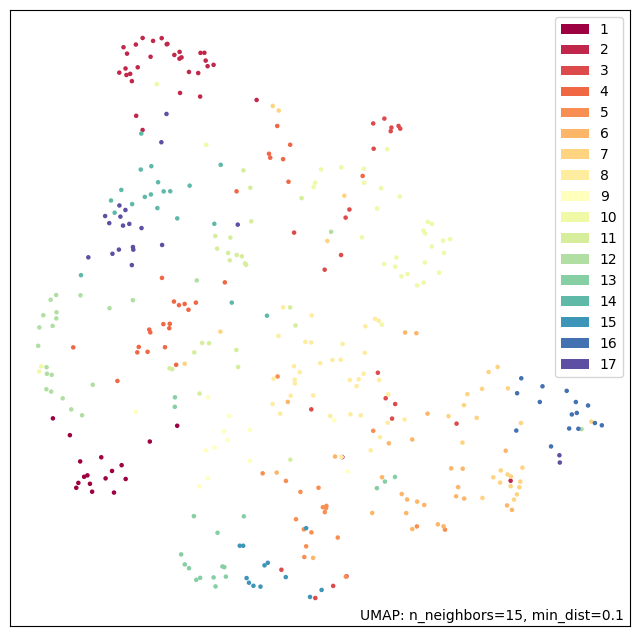

In [27]:
umap.plot.points(um, labels=y)

#Coronavirus with 6 clusters

In [28]:
with open('/content/drive/MyDrive/coronavirus.txt', 'r') as file:
  lines = file.read()

In [29]:
tmtm = Trial_MicroTopicModeller(n_clusters=7)
sent_embs = tmtm.get_embeddings(lines)
emb_clusters, sent_collection = tmtm.get_sentence_clusters(sent_embs)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [30]:
X = []
y = []
for i in range(1, len(sent_collection)):
    for j in range(len(sent_collection[i])):
        X.append(emb_clusters[i][j])
        y.append(i)

assert len(X) == len(y)

y = np.array(y)

In [31]:
md = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='canberra')
um = md.fit(X)

In [32]:
data = tmtm.data
distributions = []
vectorizer = CountVectorizer(stop_words='english', max_features=40000)
vectorizer.fit(data)
for i in range(len(sent_collection)):
    if len(sent_collection[i]) > 0:
        base_words = get_lda(vectorizer, sent_collection, i)
        distributions.append(base_words)
    common_key_words = get_common_key_words(distributions)
    topic_words = get_topic_words(distributions, common_key_words)
    topic_words['common_key_words'] = common_key_words

print(topic_words)

{'topic0': ['clear', 'concede', 'illness', 'time', 'indications', 'introduce', 'country', 'remain', 'globally', 'trade', 'january', 'saying', 'reported', 'publicly', 'calm', 'fever', 'restrictions'], 'topic1': ['city', 'person', 'detected', 'symptoms', 'chance', 'reports', 'things', 'dealt'], 'topic2': ['soon', 'resort', 'officials', 'bangkok', 'number', 'controls', 'coronavirus'], 'topic3': ['analysis', 'sunday', 'seven', 'seafood', 'centre', '324', 'condition', 'hospital'], 'topic4': ['attempts', '2002', 'hong', 'weeks', 'syndrome', 'initial', 'colleagues', 'masks', 'stockpiled', 'reporting', 'respiratory', 'china', 'face', 'mistrust', 'citizens', 'investigations', 'warn'], 'topic5': ['emergence', 'month', 'hours', 'ministry', 'media', '30', 'south', 'contracted', 'authorities', 'second', 'infected'], 'common_key_words': ['outbreak', 'spread', 'human', 'transmission', 'said', 'travel', 'cases', 'mayer', 'disease', 'health', 'population', 'confirmed', 'wuhan', 'new', 'chinese', 'virus

<Axes: >

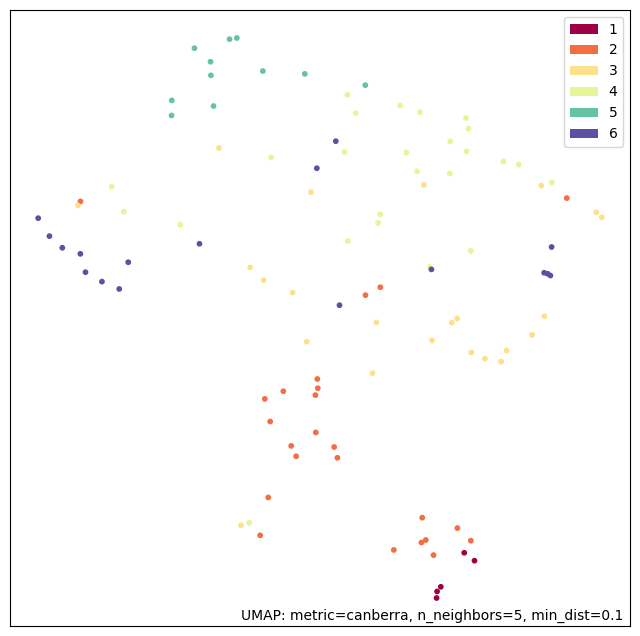

In [33]:
umap.plot.points(um, labels=y)

#Coronavirus-2 with 7 clusters

In [34]:
with open('/content/drive/MyDrive/coronavirus_part_2.txt', 'r') as file:
  lines = file.read()

In [35]:
tmtm = Trial_MicroTopicModeller(n_clusters=8)
sent_embs = tmtm.get_embeddings(lines)
emb_clusters, sent_collection = tmtm.get_sentence_clusters(sent_embs)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [36]:
X = []
y = []
for i in range(1, len(sent_collection)):
    for j in range(len(sent_collection[i])):
        X.append(emb_clusters[i][j])
        y.append(i)

assert len(X) == len(y)

y = np.array(y)

In [37]:
md = umap.UMAP(n_neighbors=5, min_dist=0.1)
um = md.fit(X)

In [38]:
data = tmtm.data
distributions = []
vectorizer = CountVectorizer(stop_words='english', max_features=40000)
vectorizer.fit(data)
for i in range(len(sent_collection)):
    if len(sent_collection[i]) > 0:
        base_words = get_lda(vectorizer, sent_collection, i)
        distributions.append(base_words)
    common_key_words = get_common_key_words(distributions)
    topic_words = get_topic_words(distributions, common_key_words)
    topic_words['common_key_words'] = common_key_words

print(topic_words)

{'topic0': ['opposition', 'media', 'hunt', 'social', 'minister', 'lockdown', 'weekend', 'johnson', 'stressing', 'letter'], 'topic1': ['li', 'pandemic', 'weeks', 'crowds', 'long', 'total', 'walk', 'perspective', 'virus', 'talk', 'gap', 'underplaying', 'number', 'power', 'boyd'], 'topic2': ['street', 'year', 'notice', 'province', 'stop', 'airport', 'stations', 'ezhou', 'day', 'train', 'passengers', 'temple', 'cancelled', 'shelves', 'outgoing', 'spring', 'term', 'announced'], 'topic3': ['risks', 'outbreak', 'security', 'ghs', 'environment', 'london', 'world', 'biological', 'session', 'reported', 'pandemics', 'government', 'evidence'], 'topic4': ['home', 'limit', 'bs', 'overwhelm', 'ill', 'avoid', 'feared', 'scale', 'pubs', 'crowded', 'hotels', 'movements', 'force', 'tour'], 'topic5': ['zika', 'say', '000', 'local', '571', 'pharmacies', 'masks', '95', 'face', 'critical', 'current', 'official', 'identified', 'chinese', 'infected', 'patients', 'hospital'], 'topic6': ['attendance', 'new', 'sc

<Axes: >

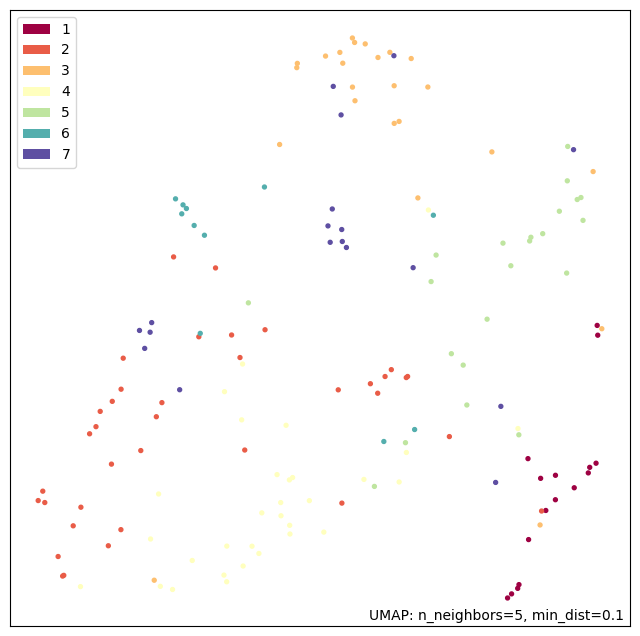

In [39]:
umap.plot.points(um, labels=y)

#Coronavirus-fr with 7 clusters

In [40]:
with open('/content/drive/MyDrive/french_coronavirus.txt', 'r') as file:
  lines = file.read()

In [41]:
tmtm = Trial_MicroTopicModeller(n_clusters=8)
sent_embs = tmtm.get_embeddings(lines)
emb_clusters, sent_collection = tmtm.get_sentence_clusters(sent_embs)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [42]:
X = []
y = []
for i in range(1, len(sent_collection)):
    for j in range(len(sent_collection[i])):
        X.append(emb_clusters[i][j])
        y.append(i)

assert len(X) == len(y)

y = np.array(y)

In [43]:
md = umap.UMAP(n_neighbors=5, min_dist=0.1)
um = md.fit(X)

In [44]:
data = tmtm.data
distributions = []
vectorizer = CountVectorizer(stop_words='english', max_features=40000)
vectorizer.fit(data)
for i in range(len(sent_collection)):
    if len(sent_collection[i]) > 0:
        base_words = get_lda(vectorizer, sent_collection, i)
        distributions.append(base_words)
    common_key_words = get_common_key_words(distributions)
    topic_words = get_topic_words(distributions, common_key_words)
    topic_words['common_key_words'] = common_key_words

print(topic_words)

{'topic0': ['être', 'paule', 'qu', 'forme', 'ne', 'elle', 'même'], 'topic1': ['effets', 'indésirables', 'reçu', '16'], 'topic2': ['global', 'adultes', 'efficace', 'où', 'ipsos', 'résultats', 'spoutnik', 'advisor', 'ligne', '20', 'intermédiaires', 'selon', 'plateforme', 'âgés'], 'topic3': ['ainsi', 'personnes', 'comirnaty', '100', 'vaccin', 'russie', 'il', 'gouvernement', 'production'], 'topic4': ['eux', 'accueillir', 'été', 'masques', 'froid', 'significatives', 'moment', 'dizaine', 'falloir', 'peuvent', 'côté', 'centre', 'sort', 'encore', 'attente', 'peu'], 'topic5': ['et', 'centaine', 'atteindre', 'tour', 'premières'], 'topic6': ['extrême', '000', 'pourrait', '55', 'cas', 'morts', 'mortes', '700', '24', 'pauvreté'], 'common_key_words': ['les', 'pour', 'que', 'le', 'au', 'dans', 'monde', 'se', 'la', 'en', 'derniers', 'satisfaire', 'spécialistes', 'fortement', 'voir', 'plus', 'avec', 'sont', 'des', 'ont', 'du', 'par', 'sans', 'vont', 'prudent', 'montée', 'décembre', 'une', 'vaccination'

<Axes: >

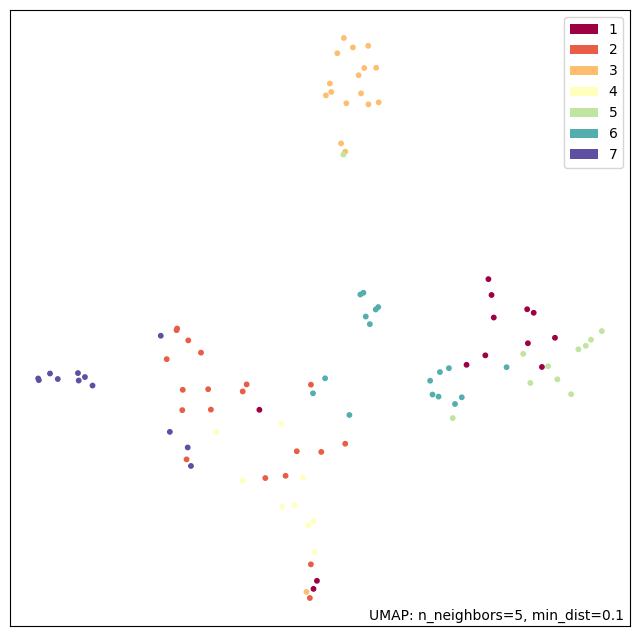

In [45]:
umap.plot.points(um, labels=y)

#Iran-fr with 7 clusters

In [46]:
with open('/content/drive/MyDrive/iran_fr .txt', 'r') as file:
  lines = file.read()

In [47]:
tmtm = Trial_MicroTopicModeller(n_clusters=8)
sent_embs = tmtm.get_embeddings(lines)
emb_clusters, sent_collection = tmtm.get_sentence_clusters(sent_embs)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [48]:
X = []
y = []
for i in range(1, len(sent_collection)):
    for j in range(len(sent_collection[i])):
        X.append(emb_clusters[i][j])
        y.append(i)

assert len(X) == len(y)

y = np.array(y)

In [49]:
md = umap.UMAP(n_neighbors=5, min_dist=0.1)
um = md.fit(X)

In [50]:
data = tmtm.data
distributions = []
vectorizer = CountVectorizer(stop_words='english', max_features=40000)
vectorizer.fit(data)
for i in range(len(sent_collection)):
    if len(sent_collection[i]) > 0:
        base_words = get_lda(vectorizer, sent_collection, i)
        distributions.append(base_words)
    common_key_words = get_common_key_words(distributions)
    topic_words = get_topic_words(distributions, common_key_words)
    topic_words['common_key_words'] = common_key_words

print(topic_words)

{'topic0': ['que', 'affaire', 'slogans', 'publics'], 'topic1': ['vendredi', 'nationale', 'pivet', 'français', 'iraniennes', 'femmes', 'vidéo', 'politiques', 'police', 'ennemi'], 'topic2': ['ans', '22'], 'topic3': ['qu', 'aussitôt', 'après', 'son', 'annonce', 'hôpital', 'morte', 'coma'], 'topic4': ['certains', 'inédite', 'parcouru', 'contestation', 'plus', 'sont', 'années', 'depuis', 'autorités', 'twitter', 'vague'], 'topic5': ['restent', 'al', 'port', 'partout', 'porte', 'oui', 'palestiniens', 'parlé', 'turban'], 'topic6': ['organisation', 'bilan', 'donné', 'lourd', 'fait', 'violence', 'contre', 'rassemblement', 'haut', 'réaction', 'téhéran'], 'common_key_words': ['et', 'des', 'les', 'le', 'manifestants', 'la', 'capitale', 'cinéastes', 'face', 'lieu', 'politique', 'ont', 'du', 'une', 'par', 'dans', 'mahsa', 'amini', 'visite', 'mort', 'est', 'elle', 'en', 'iran', 'non', 'au', 'égalité', 'liberté']}


<Axes: >

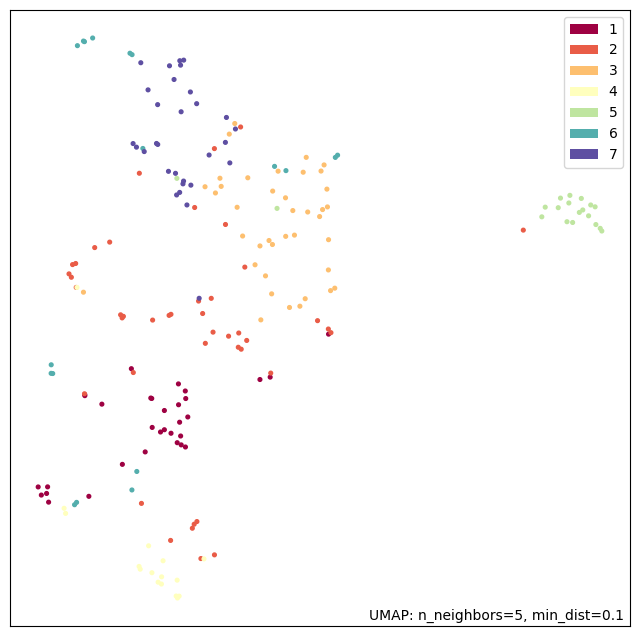

In [51]:
umap.plot.points(um, labels=y)

#Iran-fr with 15 clusters

In [52]:
with open('/content/drive/MyDrive/iran_fr .txt', 'r') as file:
  lines = file.read()

In [53]:
tmtm = Trial_MicroTopicModeller(n_clusters=16)
sent_embs = tmtm.get_embeddings(lines)
emb_clusters, sent_collection = tmtm.get_sentence_clusters(sent_embs)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [54]:
X = []
y = []
for i in range(1, len(sent_collection)):
    for j in range(len(sent_collection[i])):
        X.append(emb_clusters[i][j])
        y.append(i)

assert len(X) == len(y)

y = np.array(y)

In [55]:
md = umap.UMAP(n_neighbors=5, min_dist=0.1)
um = md.fit(X)

In [56]:
data = tmtm.data
distributions = []
vectorizer = CountVectorizer(stop_words='english', max_features=40000)
vectorizer.fit(data)
for i in range(len(sent_collection)):
    if len(sent_collection[i]) > 0:
        base_words = get_lda(vectorizer, sent_collection, i)
        distributions.append(base_words)
    common_key_words = get_common_key_words(distributions)
    topic_words = get_topic_words(distributions, common_key_words)
    topic_words['common_key_words'] = common_key_words

print(topic_words)

{'topic0': ['partout', 'porte', 'vestimentaire', 'effondre', 'visite', '22', 'amini', 'présentée', 'palestiniens', 'une', 'parlé', 'elle', 'pour', 'mahsa', 'comme'], 'topic1': ['manifestations', 'été', 'intérim', 'aideront', 'repris', 'en', 'contre', 'rassemblement', 'réaction', 'téhéran', 'ont', 'solidarité', 'manifestants'], 'topic2': ['manifestations', 'état', 'que', 'sept', 'avaient', 'gaz', 'dont', 'tués', 'membres', 'ont', 'police', 'quatre', 'manifestants'], 'topic3': ['visiblement', 'avait', 'que', 'montrant', 'vidéo', 'enquêtes', 'une', 'femme', 'mœurs'], 'topic4': ['liberté', 'non', 'au', 'oui', 'pas', 'qui', 'femmes', 'ne', 'il', 'égalité', 'turban'], 'topic5': ['intérim', 'aideront', 'iran', 'social', 'en', 'région', 'présidentielle', 'une', 'présidente', 'depuis', 'ile'], 'topic6': ['bilan', 'qu', 'morte', 'son', 'total', 'troubles', 'hôpital', 'aujourd', 'il', 'personnes', 'elle', 'officiel'], 'topic7': ['permettant', 'par', 'que', 'au', 'sécurité', 'contre', 'iraniennes'

<Axes: >

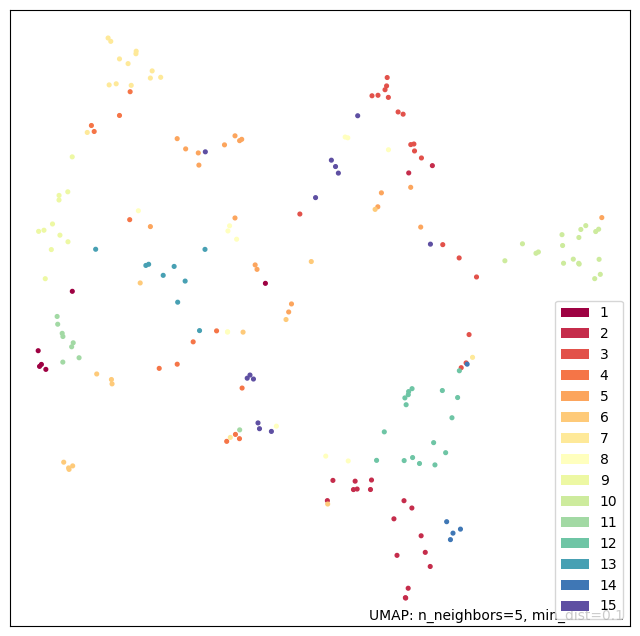

In [57]:
umap.plot.points(um, labels=y)

#Coronavirus-fr with 7 clusters

In [58]:
with open('/content/drive/MyDrive/french_coronavirus.txt', 'r') as file:
  lines = file.read()

In [59]:
tmtm = Trial_MicroTopicModeller(n_clusters=8)
sent_embs = tmtm.get_embeddings(lines)
emb_clusters, sent_collection = tmtm.get_sentence_clusters(sent_embs)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [60]:
X = []
y = []
for i in range(1, len(sent_collection)):
    for j in range(len(sent_collection[i])):
        X.append(emb_clusters[i][j])
        y.append(i)

assert len(X) == len(y)

y = np.array(y)

In [61]:
md = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='manhattan')
um = md.fit(X)

In [62]:
data = tmtm.data
distributions = []
vectorizer = CountVectorizer(stop_words='english', max_features=40000)
vectorizer.fit(data)
for i in range(len(sent_collection)):
    if len(sent_collection[i]) > 0:
        base_words = get_lda(vectorizer, sent_collection, i)
        distributions.append(base_words)
    common_key_words = get_common_key_words(distributions)
    topic_words = get_topic_words(distributions, common_key_words)
    topic_words['common_key_words'] = common_key_words

print(topic_words)

{'topic0': ['extrême', '700', '000', 'pourrait', '55', 'morts', 'mortes', 'france', 'ont', '24', 'pauvreté'], 'topic1': ['avons', 'vaccinations', 'vu', 'prévues', 'il', 'elle', 'nous', 'si'], 'topic2': ['être', 'qu', 'préfèrent', 'significatives', 'moment', 'dizaine', 'prendre', 'ce', 'rendez', 'froid', 'attente', 'peu'], 'topic3': ['arrivées', 'tour', 'atteindre', 'paris'], 'topic4': ['spoutnik', 'marché', 'pays'], 'topic5': ['clinique', 'avec', 'pas', 'ne', 'côté', 'faudra', 'définitives'], 'topic6': ['royaume', 'campagne', 'commencé', 'sont', 'tête', 'unis'], 'common_key_words': ['plus', 'cas', 'la', 'dans', 'vont', 'prudent', 'montée', 'décembre', 'le', 'par', 'les', 'une', 'en', 'premières', 'sur', 'ainsi', 'du', 'pour', 'que', 'monde', 'se', 'centre', 'des', 'au', 'vaccination', 'derniers', 'satisfaire', 'spécialistes', 'fortement', 'voir', 'et', 'est']}


<Axes: >

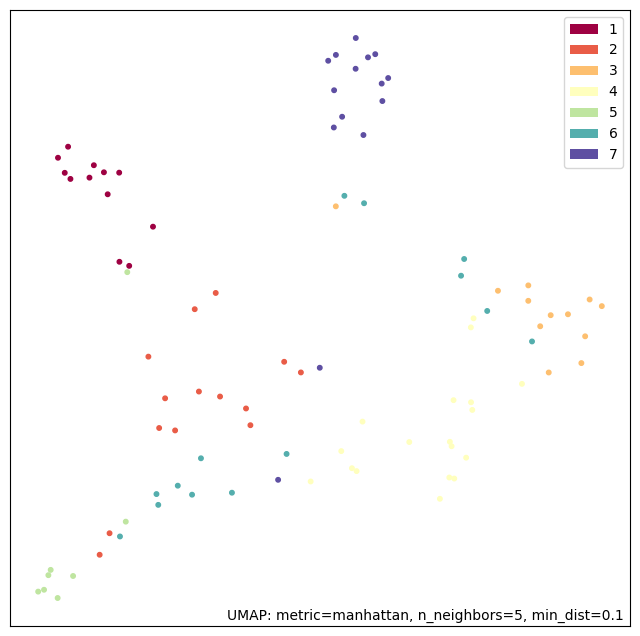

In [63]:
umap.plot.points(um, labels=y)